In [ ]:
import os
import random
import re
import math
import time
import functools
random.seed(a=42)
from itertools import cycle
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, roc_curve, auc, f1_score, confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.utils import class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier

import lightgbm

import warnings
warnings.filterwarnings('ignore')

sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/

Mounted at /content/drive
MyDrive


In [ ]:
DRIVE_DIRECTORY = "/content/drive/MyDrive"

OUTPUT_DIR = DRIVE_DIRECTORY + "/renal_carcinoma/_output"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENES_DIR = OUTPUT_DIR + "/anova"
if not os.path.exists(GENES_DIR):
    os.makedirs(GENES_DIR)

training_file = 'training_set.csv'
test_file = 'test_set.csv'

training_labels = 'training_labels.csv'
test_labels = 'test_labels.csv'

In [ ]:
train_data = pd.read_csv(training_file, index_col=0)
test_data = pd.read_csv(test_file, index_col=0)

train_labels = pd.read_csv(training_labels, index_col=0)
test_labels = pd.read_csv(test_labels, index_col=0)

In [ ]:
train_data.head()

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001561.7,ENSG00000001617.12,ENSG00000001626.16,...,ENSG00000287627.1,ENSG00000287649.1,ENSG00000287733.1,ENSG00000287770.1,ENSG00000287837.1,ENSG00000288003.1,ENSG00000288057.1,ENSG00000288066.1,ENSG00000288162.1,ENSG00000288545.1
TCGA-SX-A71S-01A,48.3953,0.0000,84.1344,9.7777,42.1879,101.1447,29.2480,36.3200,117.8496,0.4795,...,0.1251,0.0000,11.0668,0.0000,4.8663,0.0000,0.000,45.8299,0.1325,0.1035
TCGA-BQ-7051-01A,72.3775,0.1354,90.8544,2.2342,8.1109,106.9732,73.7317,31.1117,7.9526,0.0523,...,0.0661,0.0243,15.8320,0.0000,1.4569,0.0000,0.014,21.5157,0.0700,0.0000
TCGA-B2-5635-01A.1,28.8629,0.2152,67.0498,34.4290,46.0427,59.8095,9.6487,44.9480,126.4023,0.3450,...,0.0000,8.8593,48.4421,0.0000,3.0638,19.9184,0.000,34.7520,2.1879,0.0869
TCGA-BP-4967-01A,51.9280,0.1329,69.3944,7.4124,9.8914,52.0490,10.8936,29.6939,79.0725,0.6906,...,0.1297,9.1269,16.7283,0.0000,1.8081,35.6296,0.000,12.1059,1.1222,0.1610
TCGA-B8-5552-01B,34.3976,1.3407,78.6941,29.6986,94.5079,68.8465,19.1207,47.0522,174.6127,0.3800,...,1.0903,5.0031,9.1114,6.1868,3.3421,10.6716,0.000,29.7941,12.6020,0.2461


In [ ]:
genes = train_data.columns

In [ ]:
genes

Index(['ENSG00000000003.15', 'ENSG00000000005.6', 'ENSG00000000419.13',
       'ENSG00000000938.13', 'ENSG00000000971.16', 'ENSG00000001036.14',
       'ENSG00000001084.13', 'ENSG00000001561.7', 'ENSG00000001617.12',
       'ENSG00000001626.16',
       ...
       'ENSG00000287627.1', 'ENSG00000287649.1', 'ENSG00000287733.1',
       'ENSG00000287770.1', 'ENSG00000287837.1', 'ENSG00000288003.1',
       'ENSG00000288057.1', 'ENSG00000288066.1', 'ENSG00000288162.1',
       'ENSG00000288545.1'],
      dtype='object', length=8540)

In [ ]:
train_labels.head()

,project_id
871,Kidney Renal Papillary Cell Carcinoma
741,Kidney Renal Papillary Cell Carcinoma
232,Kidney Renal Clear Cell Carcinoma
389,Kidney Renal Clear Cell Carcinoma
119,Kidney Renal Clear Cell Carcinoma


In [ ]:
test_labels.head()

,project_id
332,Kidney Renal Clear Cell Carcinoma
639,Kidney Renal Papillary Cell Carcinoma
327,Kidney Renal Clear Cell Carcinoma
848,Kidney Renal Papillary Cell Carcinoma
40,Kidney Chromophobe


In [ ]:
train_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        427
Kidney Renal Papillary Cell Carcinoma    237
Kidney Chromophobe                        53
Name: project_id, dtype: int64

In [ ]:
test_labels['project_id'].value_counts()

Kidney Renal Clear Cell Carcinoma        114
Kidney Renal Papillary Cell Carcinoma     53
Kidney Chromophobe                        13
Name: project_id, dtype: int64

In [ ]:
le = LabelEncoder()
train_labels = le.fit_transform(train_labels['project_id'])
test_labels = le.transform(test_labels['project_id'])

In [ ]:
le.classes_

array(['Kidney Chromophobe', 'Kidney Renal Clear Cell Carcinoma',
       'Kidney Renal Papillary Cell Carcinoma'], dtype=object)

In [ ]:
train_labels

array([2, 2, 1, 1, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2,
       1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 0, 2, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1,
       1, 2, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 2, 0, 1, 1, 1, 0, 1, 2, 2, 1, 1, 2, 1, 2, 0,
       2, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 0,
       1, 0, 0, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2,
       0, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 2, 2,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2,
       1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1,

In [ ]:
test_labels

array([1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1,
       1, 1, 2, 1, 0, 2, 0, 2, 2, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 2, 2, 1, 2, 1,
       1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
       0, 1, 0, 1])

In [ ]:
label_mapping = {i: l for i, l in enumerate(le.classes_)}
label_mapping

{0: 'Kidney Chromophobe',
 1: 'Kidney Renal Clear Cell Carcinoma',
 2: 'Kidney Renal Papillary Cell Carcinoma'}

In [ ]:
for key, value in label_mapping.items():
    if value == 'Kidney Chromophobe':
        label_mapping[key] = 'KICH'
    elif value == 'Kidney Renal Clear Cell Carcinoma':
        label_mapping[key] = 'KIRC'
    elif value == 'Kidney Renal Papillary Cell Carcinoma':
        label_mapping[key] = 'KIRP'
    else:
        pass

In [ ]:
label_mapping

{0: 'KICH', 1: 'KIRC', 2: 'KIRP'}

In [ ]:
random_state = 42

In [ ]:
metrics = ["Accuracy", "Precision", "Recall", "Specificity", "F1", "AUC"]

In [ ]:
def plot_roc_curve(y_test, y_pred, model_name):

    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(7,5))
    #plt.figure(dpi=200)
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
      label="Micro",
      color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
      label="Macro",
      color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
          label="{0}".format(label_mapping[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate", weight='bold')
    plt.ylabel("True Positive Rate", weight='bold')
    plt.title(f"{model_name} ROC Curve", weight='bold')
    plt.legend()
    plt.savefig(GENES_DIR + f'/{model_name}_rocauc.png', facecolor='w', dpi=200, bbox_inches='tight')

In [ ]:
def evaluate(model, model_name, test_data, test_labels):
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(test_data)
    cnf_matrix = confusion_matrix(y_test, predictions)

    num_classes = len(cnf_matrix)
    accuracy, precision, recall, specificity, f1_score = [], [], [], [], []

    for i in range(num_classes):
        true_positives = cnf_matrix[i, i]
        false_negatives = sum(cnf_matrix[i, :]) - true_positives
        false_positives = sum(cnf_matrix[:, i]) - true_positives
        true_negatives = sum(sum(cnf_matrix)) - false_positives - false_negatives - true_positives

        acc = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
        prec = (true_positives) / (true_positives + false_positives)
        rec = (true_positives) / (true_positives + false_negatives)
        spec = (true_negatives) / (true_negatives + false_positives)
        f1 = 2 * (prec * rec) / (prec + rec)

        accuracy.append(acc*100)
        precision.append(prec*100)
        recall.append(rec*100)
        specificity.append(spec*100)
        f1_score.append(f1*100)

    total_accuracy = np.mean(accuracy)
    total_precision = np.mean(precision)
    total_recall = np.mean(recall)
    total_specificity = np.mean(specificity)
    total_f1 = np.mean(f1_score)
    roc_auc = roc_auc_score(test_labels, probabilities, multi_class='ovr')*100

    print('- Results:')
    print(f"Accuracy: {total_accuracy:.2f}%")
    print(f"Precision: {total_precision:.2f}%")
    print(f"Recall: {total_recall:.2f}%")
    print(f"Specificity: {total_specificity:.2f}%")
    print(f"F1: {total_f1:.2f}%")
    print(f"AUC: {roc_auc:.2f}%")

    d = []
    for class_num in range(num_classes):
        d.append(
            {
                'Accuracy': f'{accuracy[class_num]:.2f}',
                'Precision': f'{precision[class_num]:.2f}',
                'Recall':  f'{recall[class_num]:.2f}',
                'Specificity': f'{specificity[class_num]:.2f}',
                'F1': f'{f1_score[class_num]:.2f}',
            }
        )

    per_class_metric = pd.DataFrame(d, index=label_mapping.values())
    per_class_metric = per_class_metric.T
    print("\n- Results per class:")
    display(per_class_metric)


    cnf_matrix = cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:, np.newaxis]
    #cnf_matrix *= 100

    ax= plt.subplot()
    sns.heatmap(cnf_matrix, annot=True, cmap='Greens', annot_kws={"weight": "bold", "size": 12},
                fmt='.1%', ax=ax)

    ax.xaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    ax.yaxis.set_ticklabels([label_mapping[0], label_mapping[1], label_mapping[2]], weight='bold')
    plt.savefig(GENES_DIR + f'/{model_name}_confmatrix.png', facecolor='w', dpi=200, bbox_inches='tight')


    plot_roc_curve(y_test=test_labels, y_pred=probabilities, model_name=model_name)


    results = pd.DataFrame(
        [f"{total_accuracy:.2f}", f"{total_precision:.2f}", f"{total_recall:.2f}",
         f"{total_specificity:.2f}", f"{total_f1:.2f}", f"{roc_auc:.2f}"],
        index = metrics,
        columns = [model_name]
    )

    return results

In [ ]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [ ]:
search_metrics = {
    "Accuracy": "accuracy",
    "Balanced accuracy": "balanced_accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "AUC": roc_auc_scorer
}

In [ ]:
def get_scores(model, metrics):
    scores = dict()
    for metric in metrics.keys():
        best_index = np.nonzero(model.cv_results_["rank_test_%s" % metric] == 1)[0][0]
        best_score = model.cv_results_["mean_test_%s" % metric][best_index]
        scores[metric] = f"{best_score:.4f}"
        print(f"{metric}: {best_score:.4f}")
    return scores

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [ ]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels),
    y=train_labels
)

class_weights = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weights)

{0: 4.509433962264151, 1: 0.5597189695550351, 2: 1.0084388185654007}


In [ ]:
feature_selector = SelectKBest(score_func=f_classif)

In [ ]:
X_train = train_data
X_test = test_data

y_train = train_labels
y_test = test_labels

### A. Logistic Regression <a class="anchor" id="logistic_regression_tuning"></a>

In [ ]:
model = LogisticRegression(class_weight=class_weights, random_state=random_state, n_jobs=-1)

In [ ]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("logistic", model)])

In [ ]:
space = dict()
space['selector__k'] = [150, 200, 250, 300, 350]
space['logistic__solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['logistic__penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['logistic__C'] = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

In [ ]:
logRegress_search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    n_jobs=-1, cv=cv
)
logRegress_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('logistic',
                                        LogisticRegression(class_weight={0: 4.509433962264151,
                                                                         1: 0.5597189695550351,
                                                                         2: 1.0084388185654007},
                                                           n_jobs=-1,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'logistic__C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                                         100],
                         'logistic__penalty': ['none', 'l1', 'l2',
                                               'elasticnet'],
                         'logistic__solver': ['newton-cg', 'lbfgs',
                                              'liblinear'],
                         'selector__k': [150, 200, 250, 300, 350]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [ ]:
logRegress_search.best_params_

{'logistic__C': 1e-05,
 'logistic__penalty': 'none',
 'logistic__solver': 'newton-cg',
 'selector__k': 150}

- Results:
Accuracy: 94.81%
Precision: 93.70%
Recall: 82.53%
Specificity: 94.63%
F1: 86.58%
AUC: 97.78%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,97.22,94.44,92.78
Precision,100.00,94.07,87.04
Recall,61.54,97.37,88.68
Specificity,100.00,89.39,94.49
F1,76.19,95.69,87.85


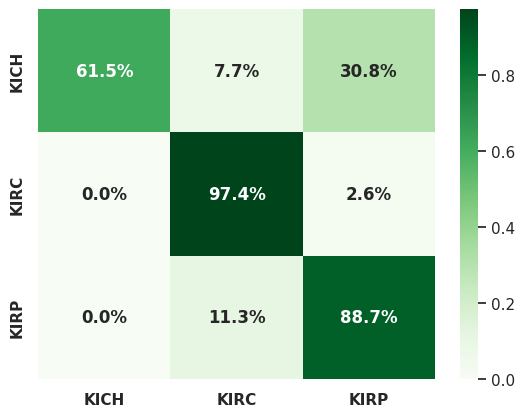

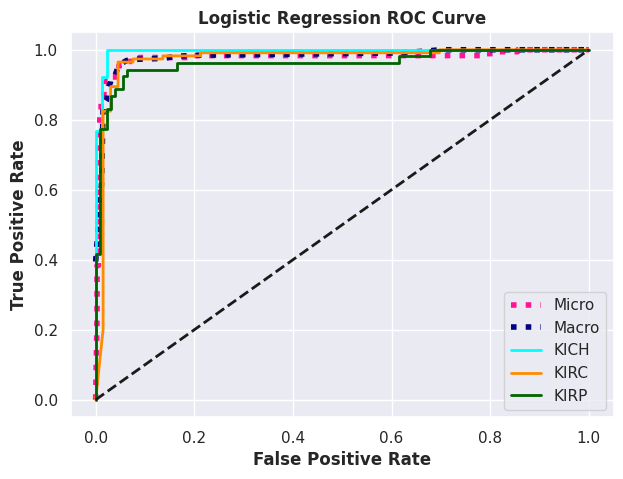

In [ ]:
log_results = evaluate(logRegress_search, "Logistic Regression", X_test, y_test)

### B. Naive Bayes <a class="anchor" id="naive_bayes_search"></a>

In [ ]:
model = GaussianNB()

In [ ]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("naive_bayes", model)])

In [ ]:
space = dict()
space['selector__k'] = [150, 200, 250, 300, 350]
space['naive_bayes__var_smoothing'] = np.logspace(0, -9, num=100)

In [ ]:
naive_bayes_search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    n_jobs=-1, cv=cv
)

naive_bayes_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('naive_bayes', GaussianNB())]),
             n_jobs=-1,
             param_grid={'naive_bayes__var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2...
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09]),
                         'selector__k': [150, 200, 250, 300, 350]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

- Results:
Accuracy: 95.56%
Precision: 87.69%
Recall: 90.27%
Specificity: 95.89%
F1: 88.83%
AUC: 98.06%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,96.67,94.44,95.56
Precision,73.33,95.61,94.12
Recall,84.62,95.61,90.57
Specificity,97.60,92.42,97.64
F1,78.57,95.61,92.31


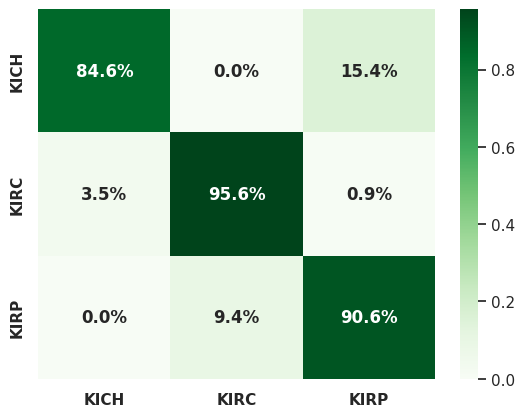

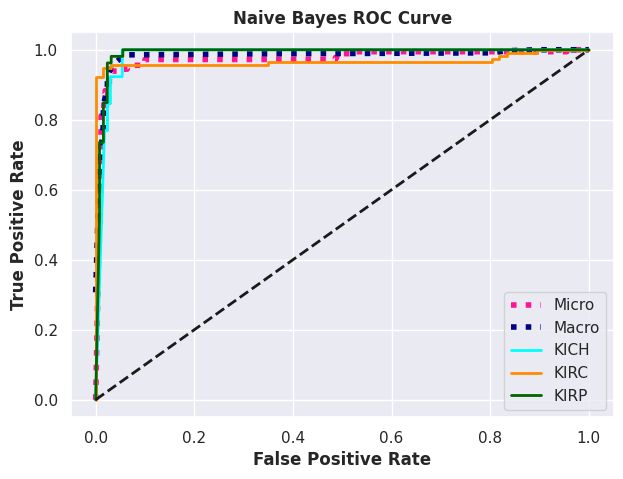

In [ ]:
naive_bayes_results = evaluate(naive_bayes_search, "Naive Bayes", X_test, y_test)

### D. Support Vector Machine <a class="anchor" id="svm_tuning"></a>

In [ ]:
model = SVC(class_weight=class_weights, random_state=random_state, probability=True)

In [ ]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("svm", model)])

In [ ]:
space = dict()
space['selector__k'] = [150, 200, 250, 300, 350]
space['svm__C'] = [0.1,1, 10, 100]
space['svm__gamma'] = [1,0.1,0.01,0.001]
space['svm__kernel'] = ['poly', 'sigmoid']

In [ ]:
svc_search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    n_jobs=-1, cv=cv
)

svc_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('svm',
                                        SVC(class_weight={0: 4.509433962264151,
                                                          1: 0.5597189695550351,
                                                          2: 1.0084388185654007},
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'selector__k': [150, 200, 250, 300, 350],
                         'svm__C': [0.1, 1, 10, 100],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['poly', 'sigmoid']},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [ ]:
svc_search.best_params_

{'selector__k': 150, 'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'poly'}

- Results:
Accuracy: 97.04%
Precision: 96.74%
Recall: 85.63%
Specificity: 96.69%
F1: 89.64%
AUC: 98.23%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,97.22,96.67,97.22
Precision,100.00,95.76,94.44
Recall,61.54,99.12,96.23
Specificity,100.00,92.42,97.64
F1,76.19,97.41,95.33


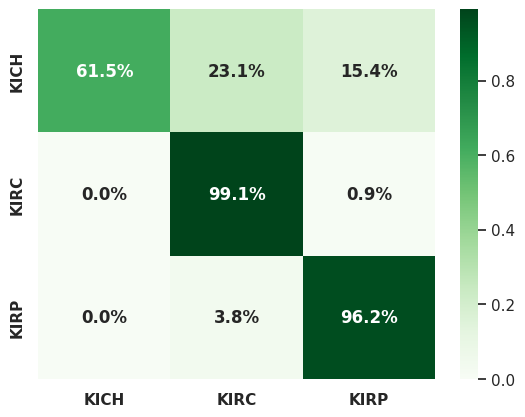

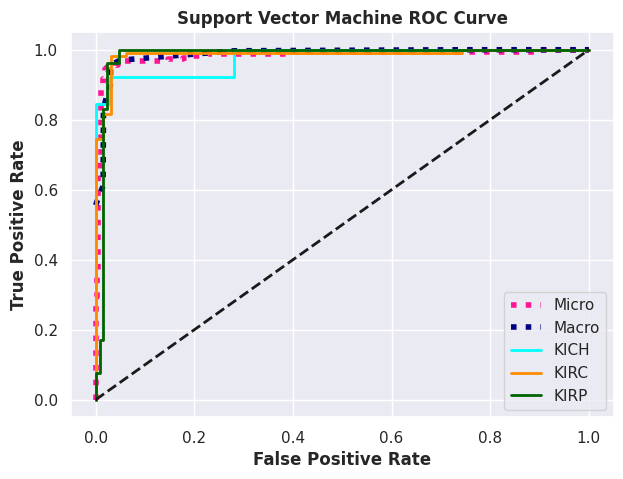

In [ ]:
svc_search_results = evaluate(svc_search, "Support Vector Machine", X_test, y_test)

### E. Decision Tree <a class="anchor" id="dtree_tuning"></a>

In [ ]:
model = DecisionTreeClassifier(class_weight=class_weights, random_state=random_state)

In [ ]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("dtree", model)])

In [ ]:
space = dict()
space['selector__k'] = [150, 200, 250, 300, 350]
space['dtree__max_features'] = ['auto', 'sqrt', 'log2']
space['dtree__ccp_alpha'] = [0.0, 0.1, 0.01, 0.001]
space['dtree__max_depth'] = [3, 4, 5, 6, 7, 8, 9]
space['dtree__criterion'] = ['gini', 'entropy']

In [ ]:
dtree_search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    n_jobs=-1, cv=cv
)

dtree_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('dtree',
                                        DecisionTreeClassifier(class_weight={0: 4.509433962264151,
                                                                             1: 0.5597189695550351,
                                                                             2: 1.0084388185654007},
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'dtree__ccp_alpha': [0.0, 0.1, 0.01, 0.001],
                         'dtree__criterion': ['gini', 'entropy'],
                         'dtree__max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'dtree__max_features': ['auto', 'sqrt', 'log2'],
                         'selector__k': [150, 200, 250, 300, 350]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [ ]:
dtree_search.best_params_

{'dtree__ccp_alpha': 0.0,
 'dtree__criterion': 'gini',
 'dtree__max_depth': 3,
 'dtree__max_features': 'auto',
 'selector__k': 150}

- Results:
Accuracy: 95.56%
Precision: 86.81%
Recall: 93.21%
Specificity: 96.44%
F1: 89.51%
AUC: 96.82%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,96.67,93.89,96.11
Precision,70.59,97.25,92.59
Recall,92.31,92.98,94.34
Specificity,97.01,95.45,96.85
F1,80.00,95.07,93.46


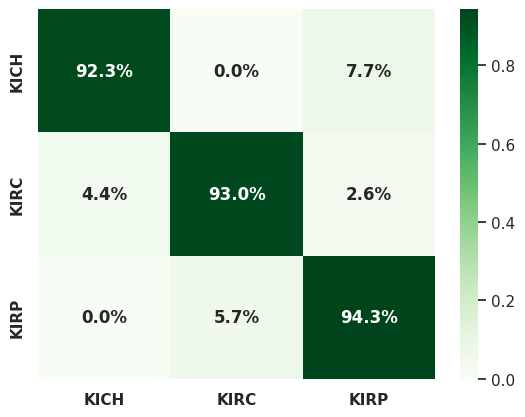

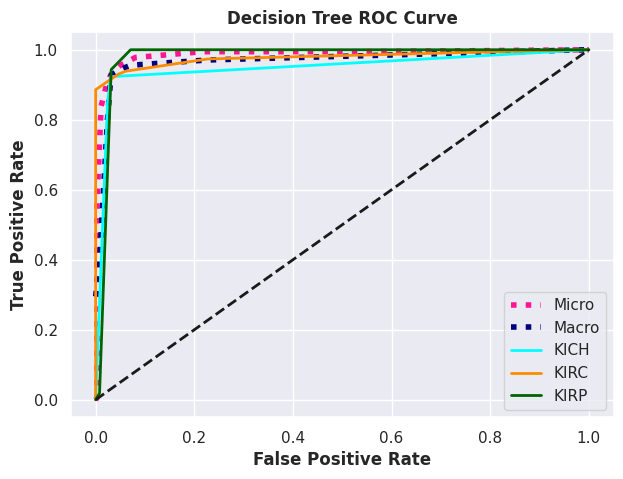

In [ ]:
dtree_search_results = evaluate(dtree_search, "Decision Tree", X_test, y_test)

### G. Extra Trees Classifier <a class="anchor" id="etc_tuning"></a>

In [ ]:
model = ExtraTreesClassifier(class_weight=class_weights, random_state=random_state, n_jobs=-1)

In [ ]:
pipe = Pipeline(steps=[("scaler", StandardScaler()), ("selector", feature_selector), ("etc", model)])

In [ ]:
space = dict()
space['selector__k'] = [150, 200, 250, 300, 350]
space['etc__max_features'] = ['auto', 'sqrt', 'log2']
space['etc__n_estimators'] = [50, 100, 200, 300, 400, 500]
space['etc__max_depth'] = [3, 4, 5, 6, 7, 8, 9]
space['etc__criterion'] = ['gini', 'entropy']

In [ ]:
etc_search = GridSearchCV(
    pipe, space, scoring=search_metrics, refit="AUC",
    n_jobs=-1, cv=cv
)

etc_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector', SelectKBest()),
                                       ('etc',
                                        ExtraTreesClassifier(class_weight={0: 4.509433962264151,
                                                                           1: 0.5597189695550351,
                                                                           2: 1.0084388185654007},
                                                             n_jobs=-1,
                                                             random_state=42))]),
             n_jobs=-1,
             param_grid={'etc__criterion': ['gini', 'entropy'],
                         'etc__max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'etc__max_features': ['auto', 'sqrt', 'log2'],
                         'etc__n_estimators': [50, 100, 200, 300, 400, 500],
                         'selector__k': [150, 200, 250, 300, 350]},
             refit='AUC',
             scoring={'AUC': make_scorer(roc_auc_score, needs_threshold=True),
                      'Accuracy': 'accuracy',
                      'Balanced accuracy': 'balanced_accuracy',
                      'Precision': 'precision', 'Recall': 'recall'})

In [ ]:
etc_search.best_params_

{'etc__criterion': 'gini',
 'etc__max_depth': 3,
 'etc__max_features': 'auto',
 'etc__n_estimators': 50,
 'selector__k': 150}

- Results:
Accuracy: 96.30%
Precision: 87.88%
Recall: 92.20%
Specificity: 97.38%
F1: 89.84%
AUC: 98.49%

- Results per class:


,KICH,KIRC,KIRP
Accuracy,96.67,95.56,96.67
Precision,73.33,99.07,91.23
Recall,84.62,93.86,98.11
Specificity,97.60,98.48,96.06
F1,78.57,96.40,94.55


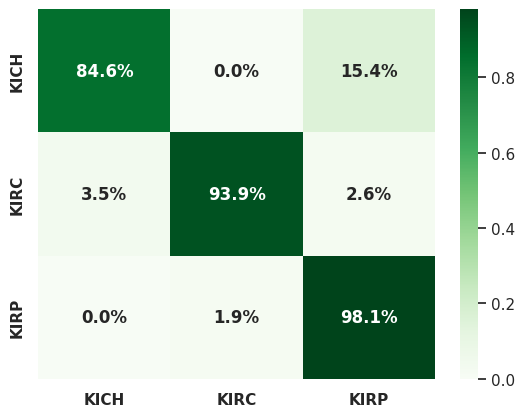

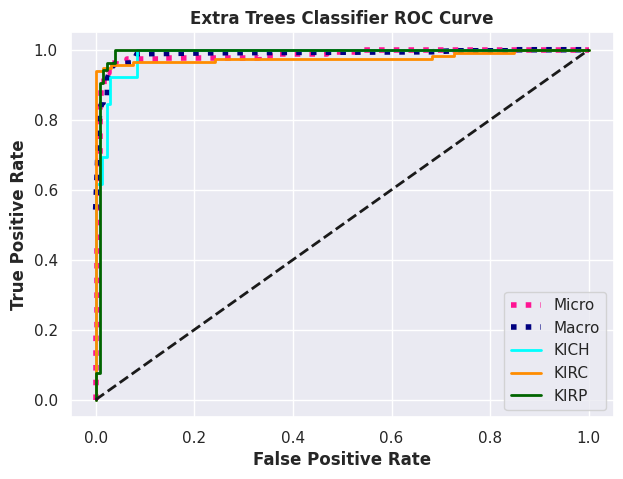

In [ ]:
etc_search_results = evaluate(etc_search, "Extra Trees Classifier", X_test, y_test)

In [ ]:
results = pd.concat([
    log_results,
    naive_bayes_results,
    svc_search_results,
    dtree_search_results,
    etc_search_results,
], axis=1)

In [ ]:
results.T

,Accuracy,Precision,Recall,Specificity,F1,AUC
Logistic Regression,94.81,93.70,82.53,94.63,86.58,97.78
Naive Bayes,95.56,87.69,90.27,95.89,88.83,98.06
Support Vector Machine,97.04,96.74,85.63,96.69,89.64,98.23
Decision Tree,95.56,86.81,93.21,96.44,89.51,96.82
Extra Trees Classifier,96.30,87.88,92.20,97.38,89.84,98.49
